# Continuous optimization - Rastrigin - dimension 500

## Importing libraries

In [2]:
import pickle
import pandas as pd
import os
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt
from numba import jit
from scipy import optimize
import pygmo as pg
from mpl_toolkits import mplot3d

In [3]:
path = '../data/'
export_path = '../data/'

Dict_funcs = {"sphere": 0, "schwefel": 1, "rosenbrock": 2, "rastrigin": 3, "griewank": 4, "ackley": 5}

funcs_name = {"sphere": "F1 : Shifted Sphere Function", "schwefel": "F2 : Schwefel’s Problem 2.21", "rosenbrock": "F3 : Shifted Rosenbrock’s Function",
                  "rastrigin": "F4 : Shifted Rastrigin’s Function",
                  "griewank": "F5 : Shifted Griewank’s Function",
                  "ackley": "F6 : Shifted Ackley’s Function"}

In [4]:
def read_values(func_name):
    values_path = str(path) + str(func_name) + '.csv'
    bias_path = str(path) + 'f_bias.csv'
    interval_path = str(path) + 'interval.csv'

    func_val = pd.read_csv(values_path)
    bias_val = pd.read_csv(bias_path)
    interval_df = pd.read_csv(interval_path,sep=';')

    funcval = func_val.List_values.values
    bias = bias_val.List_values.values[Dict_funcs[func_name]]
    search_space = list(interval_df.iloc[Dict_funcs[func_name],1:3])

    return funcval, bias, search_space

## Definition of the functions to optimize

In [5]:
@jit(nopython=True)
def eval_cost(x, dim):
    if func_name == "sphere":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z ** 2 # sum of z²
        result = F + bias # sum of z² + bias
    elif func_name == "schwefel":
        F = abs(x[0] - funcval[0]) # initial
        for i in range(1, dim - 1):
            z = x[i] - funcval[i]
            F = max(F, abs(z)) # max 'absZ_i, i in [1,D]}
        result = F + bias
    elif func_name == "rosenbrock":
        F = 0
        z = np.empty(dim)
        for i in range(dim - 1):
            z[i] = x[i] - funcval[i] + 1
        for i in range(dim - 2):
            F += 100 * (z[i + 1] ** 2 - z[i] ** 2) + (1 - z[i]) ** 2
        result = F + bias
    elif func_name == "rastrigin":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z ** 2 - 10 * math.cos(2 * math.pi * z) + 10
        result = F + bias
    elif func_name == "griewank":
        F1 = 0
        F2 = 1
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F1 += z ** 2 / 4000
            F2 += math.cos(z / math.sqrt(i + 1))
        result = F1 - F2 + 1 + bias
    elif func_name == "ackley":
        Sum_0 = 0
        Sum_1 = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            Sum_0 += z ** 2
            Sum_1 += math.cos(2 * math.pi * z)
        result = -20 * math.exp(-0.2 * math.sqrt(Sum_0 / dim)) - math.exp(Sum_1 / dim) + 20 + math.e + bias
    else:
        result = 0
    return result

In [6]:
def plot_func(func_name):
    DIM = 2
    x = np.linspace(search_space[0], search_space[1], 250)
    X = np.meshgrid(x, x)

    if func_name == "sphere":
        F = 0
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            F += z ** 2
        result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "schwefel":
        F = np.abs(X[0] - funcval[0]) # initial
        for i in range(1, DIM - 1):
            z = X[i] - funcval[i]
            F = np.max(F, np.abs(z))
        result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        surf = ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()
    elif func_name == "rosenbrock":
        F = 0
        z = np.ndarray(DIM)

        for i in range(DIM - 1):
            z[i] = X[i] - np.ndarray(funcval[i]) + np.ndarray(1)
        for i in range(DIM - 2):
            F += 100 * (z[i + 1] ** 2.0 - z[i] ** 2.0) + (1 - z[i]) ** 2.0
            result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "rastrigin":
        F = 0
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            F += z ** 2 - 10 * np.cos(2 * np.pi * z) + 10
        result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "griewank":
        F1 = 0
        F2 = 1
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            F1 += z ** 2 / 4000
            F2 += np.cos(z / np.sqrt(i + 1))
        result = F1 - F2 + 1 + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "ackley":
        Sum_0 = 0
        Sum_1 = 0
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            Sum_0 += z ** 2
            Sum_1 += np.cos(2 * math.pi * z)
        result = -20 * np.exp(-0.2 * np.sqrt(Sum_0 / DIM)) - np.exp(Sum_1 / DIM) + 20 + math.e + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    else:
        result = 0

In [7]:
# Define problem Class
class Problem:
    def __init__(self, dim, bounds, glob_opt):
        self.lower = -bounds[1]
        self.upper = bounds[1]
        self.dim = dim
        self.fitness_per_eval = []
        self.glob_opt = glob_opt

    def fitness(self, x):
        result = abs(eval_cost(x, self.dim) - bias)
        return [result]

    def get_bounds(self):
        x_min = self.lower * np.ones(self.dim)
        x_max = self.upper * np.ones(self.dim)
        return x_min, x_max

In [73]:
path = '../data/'
func_name = 'rastrigin'
funcval, bias, search_space = read_values(func_name)

## Plot representation in 2D of the problem

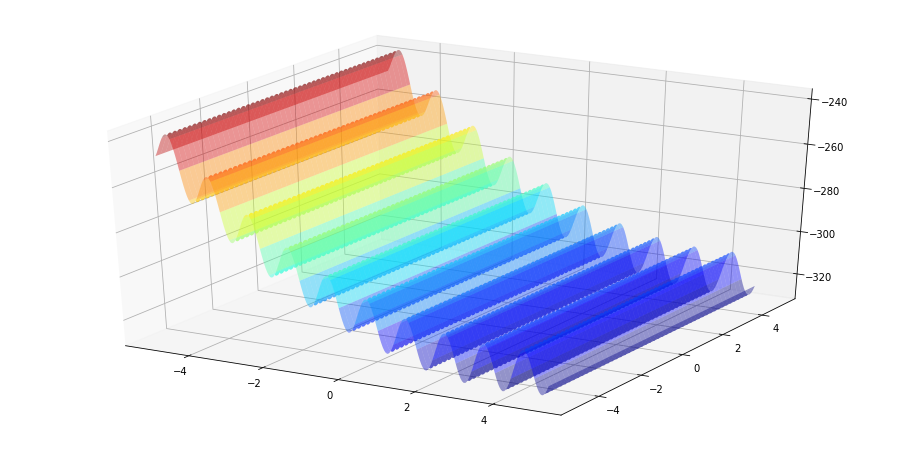

In [8]:
plot_func(func_name)

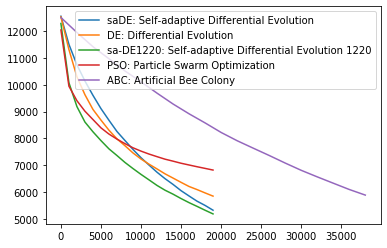

In [74]:
# choose the best algorithm for the problem
# gen = 5000
pop_size = 20
DIM = 500

List_algo = [pg.sade(gen=1000), pg.de(gen=1000), pg.de1220(gen=1000), pg.pso(gen=1000), pg.bee_colony(gen=1000, limit=20)]

plt.figure()
for uda in List_algo:
     logs = []
     for i in range(25):
         algo = pg.algorithm(uda)
         algo.set_verbosity(50) # regulates both screen and log verbosity
         prob = pg.problem(Problem(DIM, search_space, bias))
         pop = pg.population(prob, pop_size)
         pop = algo.evolve(pop)
         logs.append(algo.extract(type(uda)).get_log())
     logs = np.array(logs)
     avg_log = np.average(logs,0)

     plt.plot(avg_log[:,1],avg_log[:,2] , label=algo.get_name()) 
plt.legend()
plt.savefig("./Results/comparaison_rastrigin_500"+".png")
plt.show()

Let's try to solve the problem with the bee_colony algorithm

----------------------------------------------------------------------------------------------------
Problem dimension: 500
Function: 3
Search Space :  [-5, 5]
Global Optimum: -330.00
----------------------------------------------------------------------------------------------------
Algorithm used: ABC: Artificial Bee Colony
Parameters used : 
	Maximum number of generations: 80000
	Limit: 3000
	Verbosity: 100
	Seed: 1766494373
Fitness: 0.000000
Solution: 
            X
0    3.846594
1    4.323622
2   -2.821629
3    0.646538
..        ...
496  3.640376
497  4.166717
498  0.622400
499 -1.253914

[500 rows x 1 columns]
Number of iterations: 16000100
Stopping criterion: after 79901 iterations
computational time: 241.044 seconds


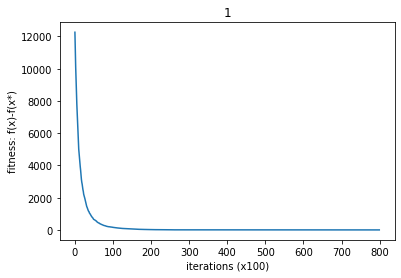

In [72]:
path = '../data/'
func_name = 'rastrigin'
funcval, bias, search_space = read_values(func_name)
DIM = 500
pop_size = 100

#omega=0.7

# algo = pg.algorithm(pg.sade(gen=5000, variant=1, variant_adptv=1, ftol=1e-06, xtol=1e-06, memory=False))
#algo = pg.algorithm(pg.pso(gen=2000, omega= 0.7, eta1=2.05, eta2=2.05, max_vel=0.8, variant=6, neighb_type=4, neighb_param=5, memory=True))
#algo = pg.algorithm(pg.simulated_annealing(Ts=10.0, Tf=10**-7, n_T_adj=1000, n_range_adj=10, bin_size=10, start_range=1.0))
algo = pg.algorithm(pg.bee_colony(gen=80000,limit=3000))
    
prob = pg.problem(Problem(DIM, search_space, bias))
pop = None
pop = pg.population(prob, pop_size)

pop.champion_x
pop.champion_f

algo.set_verbosity(100)
t1 = time.time()
pop = algo.evolve(pop)
t2 = time.time()
duration = t2 - t1

# extract_algo = algo.extract(pg.sade)
# extract_algo = algo.extract(pg.pso)
extract_algo = algo.extract(pg.bee_colony)

log = extract_algo.get_log()
curve = [x[2] for x in log]
nit = log[-1][0]

# function to make print report of function solving
algorithm_name = algo.get_name()
parameters = algo.get_extra_info()
solution_x = pop.champion_x
fitness = pop.champion_f[0]
n_evals = pop.problem.get_fevals()
print('-' * 100)
print("Problem dimension: %d" % DIM)
print("Function: %s" % Dict_funcs[func_name])
print("Search Space : ", search_space)
print("Global Optimum: %.2f" % bias)
print('-' * 100)
print("Algorithm used: %s" % algorithm_name)
print("Parameters used : \n%s" % parameters)
print("Fitness: %f" % fitness)
print("Solution: ")
with pd.option_context('display.max_rows', 8):
    print(pd.DataFrame(solution_x, columns=['X']))
print("Number of iterations: %d" % n_evals)
print("Stopping criterion: after %d iterations" % nit)
print("computational time: %.3f seconds" % duration)

plt.figure()
plt.plot(curve)
plt.title(str(i))
plt.xlabel("iterations (x100)")
plt.ylabel("fitness: f(x)-f(x*)")
plt.savefig("./Results/sol_rastrigin_500" +".png")
plt.show()